In [1]:
import os
import sys
import numpy as np


import umap.umap_ as umap

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


#ALLDIR='/mnt/d/DATA/XFMDATA/2023/Nicholls_Loren/mounts_ansto_230418/230420_qz200um_cut/tiff'
BASEDIR = ""
TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
#image_directory = ALLDIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo
['/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Al.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Ar.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-As.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Ca.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Cl.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Cr.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Cu.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Fe.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-K.tiff', '/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo/f_130um_mod-Mn.tiff', 

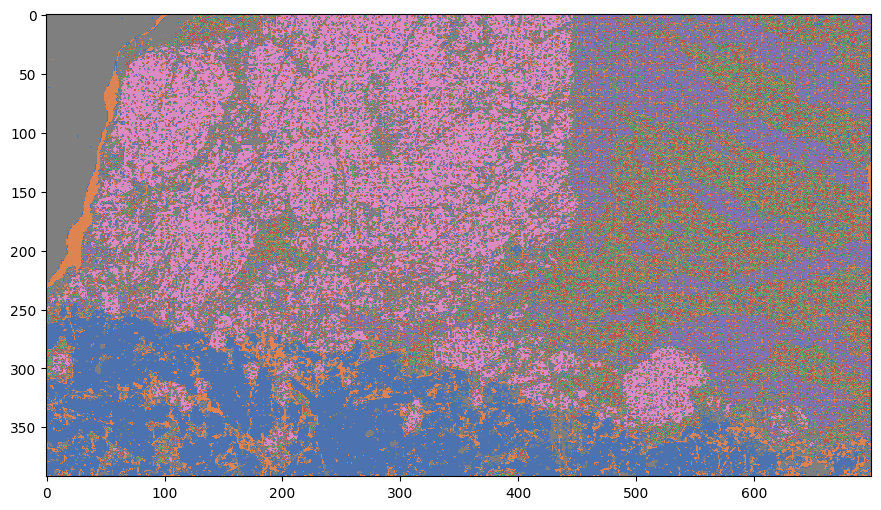

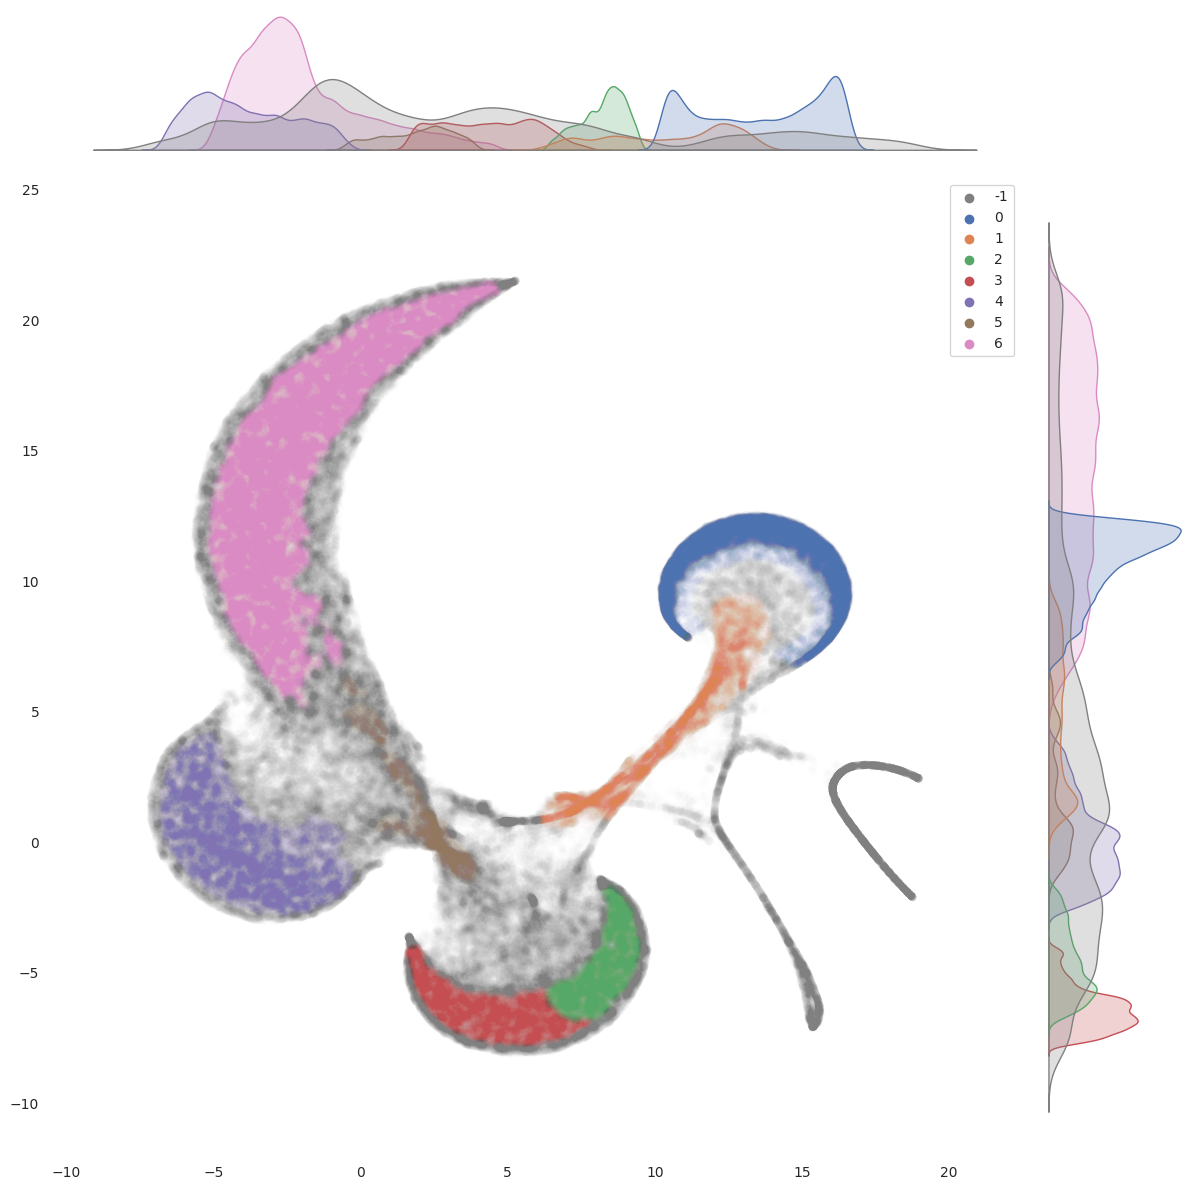

Al, max: 0.02, 98: 0.00, avg: 0.00
Ar, max: 0.50, 98: 0.01, avg: 0.00
As, max: 0.03, 98: 0.01, avg: 0.00
Ca, max: 4.66, 98: 0.87, avg: 0.08
Cl, max: 0.10, 98: 0.02, avg: 0.00
Cr, max: 0.05, 98: 0.02, avg: 0.00
Cu, max: 1.04, 98: 0.98, avg: 0.23
Fe, max: 3.36, 98: 3.18, avg: 1.99
K, max: 0.52, 98: 0.01, avg: 0.00
Mn, max: 1.54, 98: 0.09, avg: 0.02
Ni, max: 0.03, 98: 0.01, avg: 0.00
P, max: 0.21, 98: 0.03, avg: 0.00
S, max: 3.29, 98: 2.67, avg: 1.27
Si, max: 0.10, 98: 0.09, avg: 0.02
Ti, max: 4.74, 98: 0.02, avg: 0.00
V, max: 0.08, 98: 0.01, avg: 0.00
Zn, max: 1.61, 98: 0.11, avg: 0.01


In [3]:
%load_ext autoreload
%autoreload 2

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis

FORCE_EMBED=False
FORCE_CLUST=True
OVERWRITE=True

data, elements, dims = processops.compile(image_directory)

print(f"-----{elements[10]} tracker: {np.max(data[:,10])}")
categories, classavg, embedding, clusttimes, classifier = clustering.run(data, image_directory, force_embed=FORCE_EMBED, force_clust=FORCE_CLUST, overwrite=OVERWRITE)
print(f"-----{elements[10]} tracker: {np.max(data[:,10])}")

palette = vis.plot_clusters(categories, classavg, embedding, dims)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")





<Axes: ylabel='$\\lambda$ value'>

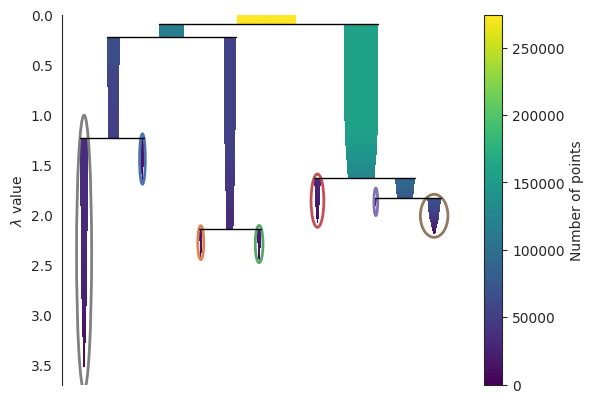

In [5]:
classifier.condensed_tree_.plot(select_clusters=True,selection_palette=palette)

In [6]:
palette

[(0.5, 0.5, 0.5),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411)]